This Colab notebook is adapted from DeepLearning. ai / Coursera assignment week 2 Course "Natural Language Processing with Attention Models" from Natural Language Processing Specialization 
- https://www.coursera.org/learn/attention-models-in-nlp/home/welcome
- https://www.coursera.org/specializations/natural-language-processing

# Transformer Summarizer

In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')   # ,force_remount=True

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/TRAX_transformer_decoder_Summarization"

/content/drive/My Drive/Colab Notebooks/TRAX_transformer_decoder_Summarization


In [3]:
!dir

data	      model.tar				       vocab_dir
model.pkl.gz  TRAX_transformer_summarizer_model.ipynb


# Install proper version of T5

In [4]:
!pip install t5==0.6.2

     |████████████████████████████████| 163kB 7.8MB/s 
     |████████████████████████████████| 368kB 13.4MB/s 
     |████████████████████████████████| 2.2MB 17.7MB/s 
     |████████████████████████████████| 3.8MB 57.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 3.4MB 54.6MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 870kB 49.2MB/s 
     |████████████████████████████████| 3.3MB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=83434c57db9131f09739511dd53e5396ac3ec4db2c770938fac9b4a262cc7275
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


# Install TRAX

In [5]:
!pip install -q -U trax==1.3.4

     |████████████████████████████████| 368kB 8.7MB/s 
     |████████████████████████████████| 1.5MB 16.2MB/s 
     |████████████████████████████████| 378kB 46.3MB/s 
     |████████████████████████████████| 358kB 50.7MB/s 
     |████████████████████████████████| 706kB 56.7MB/s 
     |████████████████████████████████| 983kB 55.6MB/s 
     |████████████████████████████████| 368kB 43.1MB/s 
     |████████████████████████████████| 194kB 61.9MB/s 
     |████████████████████████████████| 655kB 55.4MB/s 
     |████████████████████████████████| 5.6MB 5.5MB/s 
     |████████████████████████████████| 256kB 56.0MB/s 
ERROR: kfac 0.2.3 has requirement tensorflow-probability==0.8, but you'll have tensorflow-probability 0.7.0 which is incompatible.


# Load packages
- Please note that Trax Numpy is referred to as fastnp while numpy remains as np

In [6]:
import sys
import os
from termcolor import colored

import numpy as np

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

!pip list | grep trax

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


trax                          1.3.4                


# Import dataset

In [7]:
# This will download the dataset if no data_dir is specified.
# Downloading and processing can take bit of time

# Importing CNN/DailyMail articles dataset
train_stream_fn = trax.data.TFDS('cnn_dailymail',
                                 data_dir='data/',
                                 keys=('article', 'highlights'),
                                 train=True)

# This should be much faster as the data is downloaded already.
eval_stream_fn = trax.data.TFDS('cnn_dailymail',
                                data_dir='data/',
                                keys=('article', 'highlights'),
                                train=False)

Dataset cnn_dailymail downloaded and prepared to data/cnn_dailymail/3.1.0. Subsequent calls will reuse this data.


In [8]:
def tokenize(input_str, EOS=1):
    """Input str to features dict, ready for inference"""
  
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_dir='vocab_dir/',
                                      vocab_file='summarize32k.subword.subwords'))
    
    # Mark the end of the sentence with EOS
    return list(inputs) + [EOS]

def detokenize(integers):
    """List of ints to str"""
  
    s = trax.data.detokenize(integers,
                             vocab_dir='vocab_dir/',
                             vocab_file='summarize32k.subword.subwords')
    
    return wrapper.fill(s)

In [9]:
# Special tokens
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, SEP] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) # Accounting for EOS and SEP
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_dir='vocab_dir/', vocab_file='summarize32k.subword.subwords'),
    # Uses function defined above
    preprocess,
    # Filters out examples longer than 2048
    trax.data.FilterByLength(2048)
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_stream_fn())
eval_stream = input_pipeline(eval_stream_fn())

train_input, train_target, train_mask = next(train_stream)

assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [12]:
# prints mask, 0s on article, 1s on summary
print(f'Single example mask:\n\n {train_mask}')

Single example mask:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

In [13]:
# prints: [Example][<EOS>][<pad>][Example Summary][<EOS>]
print(f'Single example:\n\n {detokenize(train_input)}')

Single example:

 Chelsea's early season form may have led to comparisons with the
Arsenal 'Invincibles' side, but Gary Neville believes they aren't even
as good as the Chelsea side from 10 years ago. Jose Mourinho's side
are currently four points clear at the top of the Premier League, but
after letting leads slip against both Manchester City and United,
their killer instinct has been called into question. 'If a team are
going to be playing for a 1-0 then you better see it out,' Neville
said on Monday Night Football. 'When I saw Jose Mourinho two weeks ago
he talked about the 2005 (Chelsea) team and (compared) the team he had
then to the team he has now and he said the killer instinct's missing.
Chelsea have dropped more points from winning positions this season
than they did in the whole of 2004/05 . Chelsea took the lead against
both Manchester United and Manchester City, but drew both matches .
'When I look at the statistics they are staggering - 28 times they
(the 2004/05 team) sc

In [14]:
# Bucketing to create batched generators.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 16 sentences of length < 128 , 8 of length < 256,
# 4 of length < 512. And so on. 
boundaries =  [128, 256,  512, 1024]
batch_sizes = [16,    8,    4,    2, 1]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [15]:
# Every execution will result in generation of a different article
# Try running this cell multiple times to see how the length of the examples affects the batch size
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(1, 1213)

In [16]:
# print corresponding integer values
print(input_batch[0])

[22473  1779  3969    31   506   310   320   245   160   132 20871     4
  2557 26759   143  1151 26133    17  1019   966 12928   360     2   904
  4853 11080     4     3   207   882 12733   527    61   320   635   711
  1019  3341    28  2587   181  2635   527  1203   235   277   320   245
   160   132   213  2414   669 27978   391   897   412 27439  9275  6435
 27439  6050 13459  1628 18899  6639   153 29725   391   691   213  4177
  2248     3   244    28 17319   299  1001  1480  5779   213  3152 29725
   391  1621   831   132   213 13859  7356   229   320  1151  7872    95
   647   103  4129    50 17951   798     3     9 23817  1189   413   102
    28   846  4686  2313  3463   163  2131  5641   293     2  1752     2
   186    28  2587   527  1223     2   890   779    23  6485    22  1469
 19023     2 13022    16     2  3218  3374   186 26286 26328   132   979
   527 12289    16  2948     3     9 12467  1768 15982     4   398   966
   186  1351  4853     2  1779   316  1019    28   

In [17]:
# print the article and its summary
print('Article:\n\n', detokenize(input_batch[0]))

Article:

 Parents who encourage their young children to take part in cage
fighting contests could be jailed for child cruelty, legal experts
warn. They face sentences of up to six months for allowing a boy or
girl of primary school age to take part in the sport – described as 
‘barbaric’ by the Culture Secretary. And a Preston social club which
hosted the boys’ fight reported in the Mail yesterday is to be
investigated over whether it broke its licence conditions. The
revelations come after a video emerged showing Kian MacKinson, nine,
and a boy of eight, whose father has requested he remain anonymous,
kicking, shoving and grappling in front of baying adults. The footage
caused outrage among child and medical experts, who called for a
police and social services investigation. Brutal: Child cage fighting
can continue despite the boys being filmed without padding or head
gear . Upsetting: The young boy seen here is crying in the middle of a
fight, and is then attended by medical experts

# Summarization with transformer
1/ Dot product attention

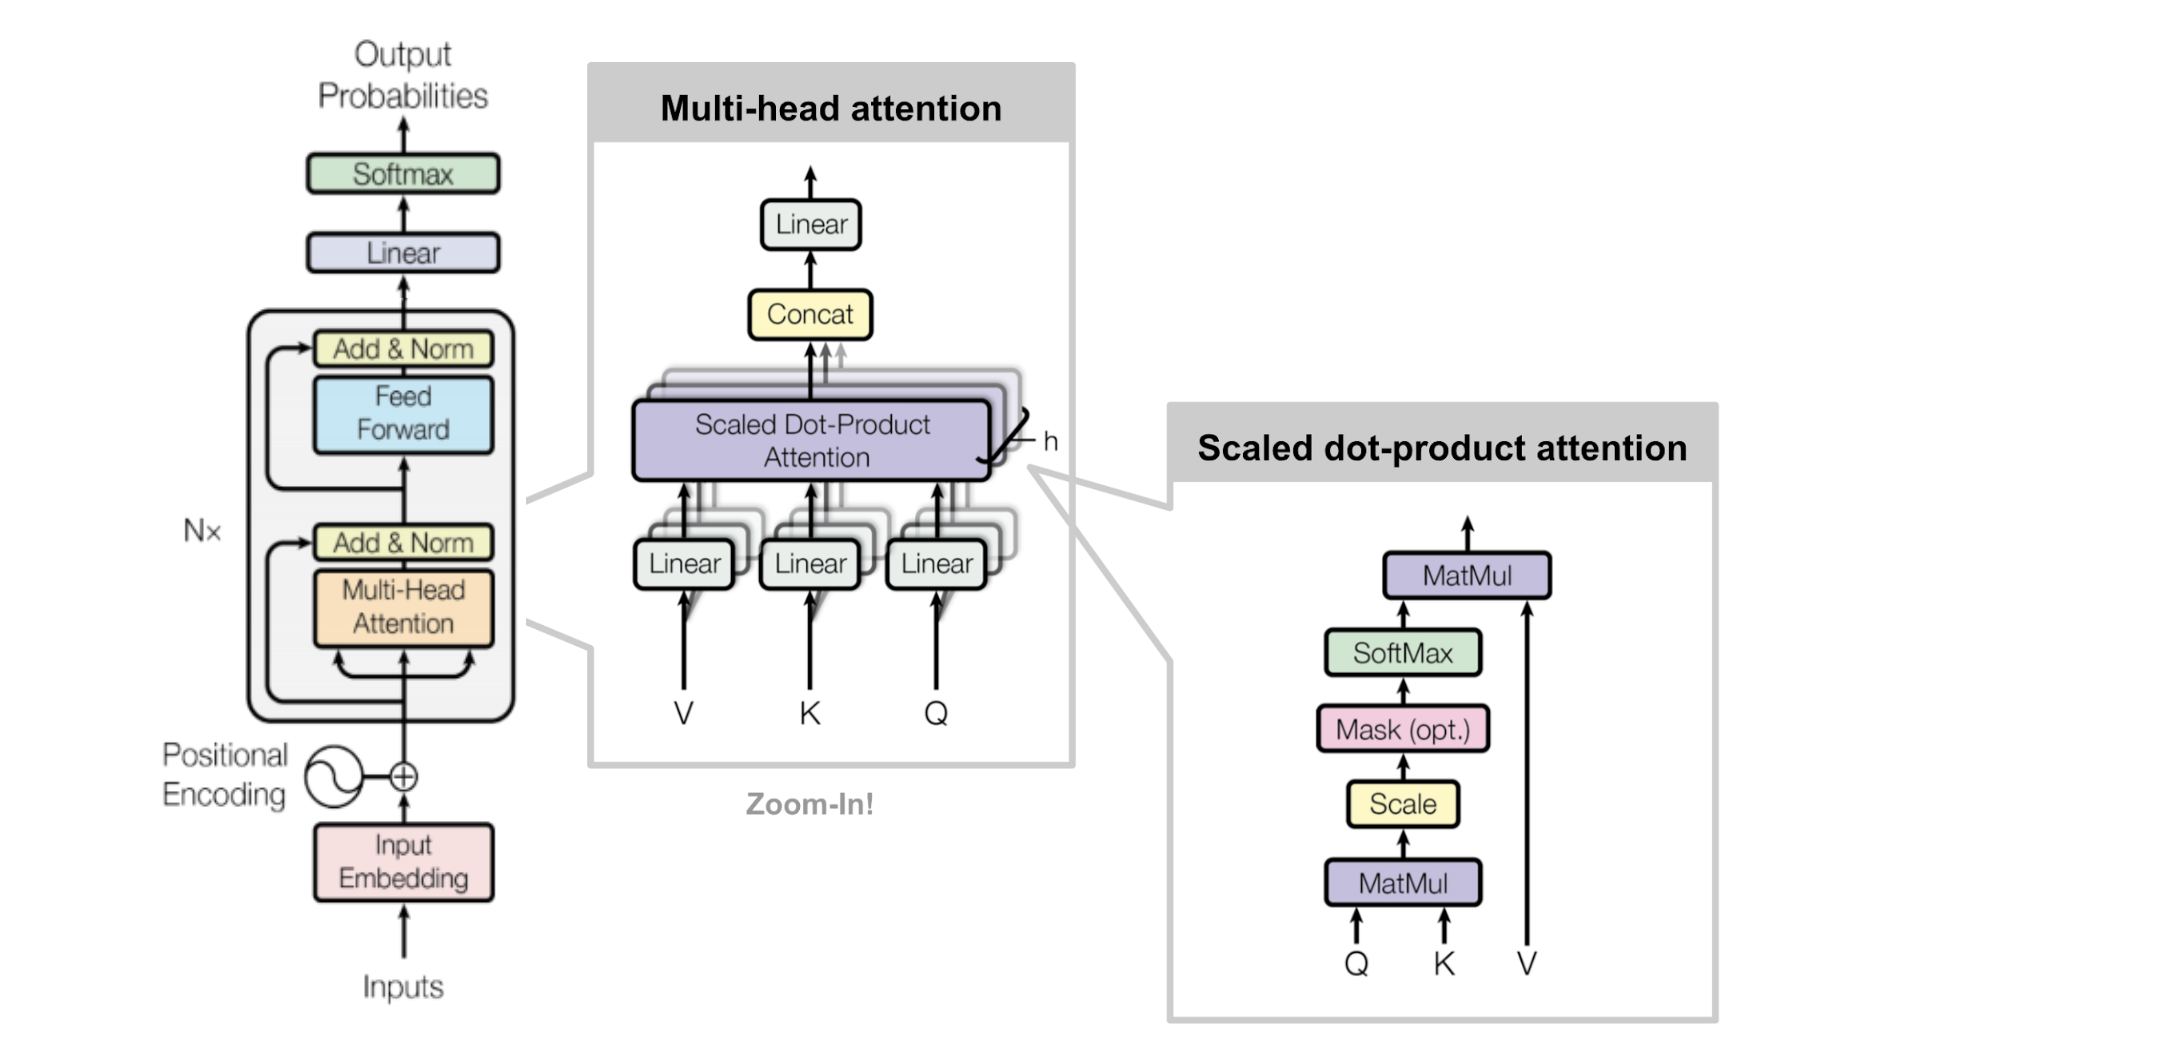

In [23]:
# DotProductAttention
def DotProductAttention(query, key, value, mask):
    """Dot product self-attention.
    Args:
        query (jax.interpreters.xla.DeviceArray): array of query representations with shape (L_q by d)
        key (jax.interpreters.xla.DeviceArray): array of key representations with shape (L_k by d)
        value (jax.interpreters.xla.DeviceArray): array of value representations with shape (L_k by d) where L_v = L_k
        mask (jax.interpreters.xla.DeviceArray): attention-mask, gates attention with shape (L_q by L_k)

    Returns:
        jax.interpreters.xla.DeviceArray: Self-attention array for q, k, v arrays. (L_q by L_k)
    """

    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Save depth/dimension of the query embedding for scaling down the dot product
    depth = query.shape[-1]

    # Calculate scaled query key dot product according to formula above
    dots = jnp.matmul(query, jnp.swapaxes(key, -2, -1)) / jnp.sqrt(depth)
    
    # Apply the mask
    if mask is not None: # The 'None' in this line does not need to be replaced
        dots = jnp.where(mask, dots, jnp.full_like(dots, -1e9))
    
    # Softmax formula implementation
    # Use trax.fastmath.logsumexp of dots to avoid underflow by division by large numbers
    # Hint: Last axis should be used and keepdims should be True
    # Note: softmax = e^(dots - logsumexp(dots)) = E^dots / sumexp(dots)
    logsumexp = trax.fastmath.logsumexp(dots, axis=-1, keepdims=True)

    # Take exponential of dots minus logsumexp to get softmax
    # Use jnp.exp()
    dots = jnp.exp(dots - logsumexp)

    # Multiply dots by value to get self-attention
    # Use jnp.matmul()
    attention = jnp.matmul(dots, value)
    
    return attention

2/ Causal Attention
- Causal attention: multi-headed attention with a mask to attend only to words that occurred before.
  - compute_attention_heads : Gets an input  𝑥  of dimension (batch_size, seqlen, n_heads  ×  d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (batch_size  ×  n_heads, seqlen, d_head).
  - dot_product_self_attention : Creates a mask matrix with False values above the diagonal and True values below and calls DotProductAttention which implements dot product self attention.
  - compute_attention_output : Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (batch_size, seqlen, n_heads  ×  d_head). These operations concatenate (stack/merge) the heads.

In [24]:
# compute_attention_heads_closure
def compute_attention_heads_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads.
        n_heads (int): number of attention heads.
    Returns:
        function: compute_attention_heads function
    """

    def compute_attention_heads(x):
        """ Compute the attention heads.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size, seqlen, n_heads X d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size X n_heads, seqlen, d_head).
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        
        # Size of the x's batch dimension
        batch_size = x.shape[0]
        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape()
        # batch_size, seqlen, n_heads*d_head -> batch_size, seqlen, n_heads, d_head
        x = jnp.reshape(x,(batch_size, seqlen, n_heads, d_head))
        # Transpose x using jnp.transpose()
        # batch_size, seqlen, n_heads, d_head -> batch_size, n_heads, seqlen, d_head
        # Note that the values within the tuple are the indexes of the dimensions of x and you must rearrange them
        x = jnp.transpose(x, (0, 2, 1, 3))
        # Reshape x using jnp.reshape()
        # batch_size, n_heads, seqlen, d_head -> batch_size*n_heads, seqlen, d_head
        x = jnp.reshape(x, (batch_size*n_heads, seqlen, d_head))
        
        ### END CODE HERE ###
        
        return x
    
    return compute_attention_heads

In [25]:
# dot_product_self_attention
def dot_product_self_attention(q, k, v):
    """ Masked dot product self attention.
    Args:
        q (jax.interpreters.xla.DeviceArray): queries.
        k (jax.interpreters.xla.DeviceArray): keys.
        v (jax.interpreters.xla.DeviceArray): values.
    Returns:
        jax.interpreters.xla.DeviceArray: masked dot product self attention tensor.
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Hint: mask size should be equal to L_q. Remember that q has shape (batch_size, L_q, d)
    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    # Notice that 1's and 0's get casted to True/False by setting dtype to jnp.bool_
    # Use jnp.tril() - Lower triangle of an array and jnp.ones()
    mask = jnp.tril(jnp.ones((1, mask_size, mask_size), dtype=jnp.bool_), k=0)
    
    ### END CODE HERE ###
    
    return DotProductAttention(q, k, v, mask)

In [26]:
# compute_attention_output_closure
def compute_attention_output_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads.
        n_heads (int): number of attention heads.
    Returns:
        function: compute_attention_output function
    """
    
    def compute_attention_output(x):
        """ Compute the attention output.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size X n_heads, seqlen, d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size, seqlen, n_heads X d_head).
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        
        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape() to shape (batch_size, n_heads, seqlen, d_head)
        x = jnp.reshape(x, (-1, n_heads, seqlen, d_head))
        # Transpose x using jnp.transpose() to shape (batch_size, seqlen, n_heads, d_head)
        x = jnp.transpose(x, (0, 2, 1, 3))
        
        ### END CODE HERE ###
        
        # Reshape to allow to concatenate the heads
        return jnp.reshape(x, (-1, seqlen, n_heads * d_head))
    
    return compute_attention_output

3/ Causal Attention Function
-  Masked multi-head attention function

In [27]:
# CausalAttention
def CausalAttention(d_feature, 
                    n_heads, 
                    compute_attention_heads_closure=compute_attention_heads_closure,
                    dot_product_self_attention=dot_product_self_attention,
                    compute_attention_output_closure=compute_attention_output_closure,
                    mode='train'):
    """Transformer-style multi-headed causal attention.

    Args:
        d_feature (int):  dimensionality of feature embedding.
        n_heads (int): number of attention heads.
        compute_attention_heads_closure (function): Closure around compute_attention heads.
        dot_product_self_attention (function): dot_product_self_attention function. 
        compute_attention_output_closure (function): Closure around compute_attention_output. 
        mode (str): 'train' or 'eval'.

    Returns:
        trax.layers.combinators.Serial: Multi-headed self-attention model.
    """
    
    assert d_feature % n_heads == 0
    d_head = d_feature // n_heads

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # HINT: The second argument to tl.Fn() is an uncalled function (without the parentheses)
    # Since you are dealing with closures you might need to call the outer 
    # function with the correct parameters to get the actual uncalled function.
    ComputeAttentionHeads = tl.Fn('AttnHeads', compute_attention_heads_closure(n_heads, d_head), n_out=1)
        

    return tl.Serial(
        tl.Branch( # creates three towers for one input, takes activations and creates queries keys and values
            [tl.Dense(d_feature), ComputeAttentionHeads], # queries
            [tl.Dense(d_feature), ComputeAttentionHeads], # keys
            [tl.Dense(d_feature), ComputeAttentionHeads], # values
        ),
        
        tl.Fn('DotProductAttn', dot_product_self_attention, n_out=1), # takes QKV
        # HINT: The second argument to tl.Fn() is an uncalled function
        # Since you are dealing with closures you might need to call the outer 
        # function with the correct parameters to get the actual uncalled function.
        tl.Fn('AttnOutput', compute_attention_output_closure(n_heads, d_head), n_out=1), # to allow for parallel
        tl.Dense(d_feature), # Final dense layer
    )


In [28]:
# Take a look at the causal attention model
print(CausalAttention(d_feature=512, n_heads=8))

Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  DotProductAttn_in3
  AttnOutput
  Dense_512
]


# Transformer decoder block

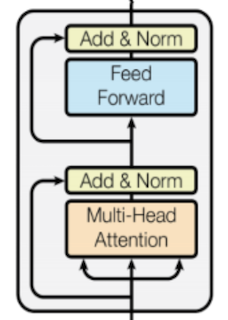

In [29]:
# DecoderBlock
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Create masked multi-head attention block using CausalAttention function
    causal_attention = CausalAttention( 
                        d_model,
                        n_heads=n_heads,
                        mode=mode
                        )
    
    # Create feed-forward block (list) with two dense layers with dropout and input normalized
    feed_forward = [ 
        # Normalize layer inputs
        tl.LayerNorm(),
        # Add first feed forward (dense) layer (don't forget to set the correct value for n_units)
        tl.Dense(d_ff),
        # Add activation function passed in as a parameter (you need to call it!)
        ff_activation(), # Generally ReLU
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode),
        # Add second feed forward layer (don't forget to set the correct value for n_units)
        tl.Dense(d_model),
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode)
    ]

    # Add list of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(),
          # Add causal attention block previously defined (without parentheses)
          causal_attention,
          # Add dropout with rate and mode specified
          tl.Dropout(rate=dropout, mode=mode),
        ),
      tl.Residual(
          # Add feed forward block (without parentheses)
          feed_forward
        ),
      ]

In [30]:
# Take a look at the decoder block
print(DecoderBlock(d_model=512, d_ff=2048, n_heads=8, dropout=0.1, mode='train', ff_activation=tl.Relu))

[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
        ]
        DotProductAttn_in3
        AttnOutput
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Relu
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


# Transformer Language Model

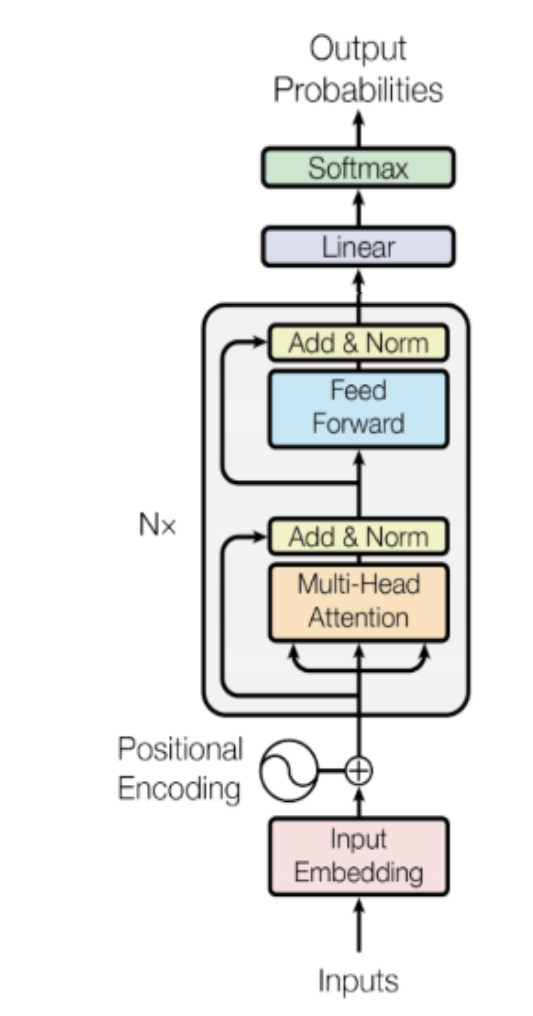

In [31]:
# TransformerLM
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Embedding inputs and positional encoder
    positional_encoder = [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode),
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)]

    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)]

    # Create the complete model as written in the figure
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(n_shifts=1, mode=mode), # Specify the mode!
        # Add positional encoder
        positional_encoder,
        # Add decoder blocks
        decoder_blocks,
        # Normalize layer
        tl.LayerNorm(),

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size),
        # Get probabilities with Logsoftmax
        tl.LogSoftmax()
    )

In [32]:
# Take a look at the Transformer : current model: TransformerLM(d_model=512, d_ff=2048, n_layers=1, n_heads=2)
print(TransformerLM(n_layers=1))

Serial[
  ShiftRight(1)
  Embedding_33300_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          DotProductAttn_in3
          AttnOutput
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Relu
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_33300
  LogSoftmax
]


# Training the model

In [33]:
from trax.supervised import training

# train_model
def training_loop(TransformerLM, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        TransformerLM (trax.layers.combinators.Serial): The model you are building.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.01)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    train_task = training.TrainTask( 
      labeled_data= train_gen, # The training generator
      loss_layer= tl.CrossEntropyLoss(), # Loss function 
      optimizer= trax.optimizers.Adam(0.01), # Optimizer (Don't forget to set LR to 0.01)
      lr_schedule= lr_schedule,
      # have a checkpoint every 10 steps
      n_steps_per_checkpoint= 10,
    )

    eval_task = training.EvalTask( 
      labeled_data= eval_gen, # The evaluation generator
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] # CrossEntropyLoss and Accuracy
    )

    ### END CODE HERE ###

    loop = training.Loop(TransformerLM(d_model=4,
                                       d_ff=16,
                                       n_layers=1,
                                       n_heads=2,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [34]:
!rm -f ~/model/model.pkl.gz
loop = training_loop(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(500)


Step      1: Ran 1 train steps in 6.50 secs
Step      1: train CrossEntropyLoss |  10.41479969
Step      1: eval  CrossEntropyLoss |  10.41456604
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 25.35 secs
Step     10: train CrossEntropyLoss |  10.41296387
Step     10: eval  CrossEntropyLoss |  10.41308308
Step     10: eval          Accuracy |  0.00000000

Step     20: Ran 10 train steps in 17.89 secs
Step     20: train CrossEntropyLoss |  10.41355324
Step     20: eval  CrossEntropyLoss |  10.40832329
Step     20: eval          Accuracy |  0.00000000

Step     30: Ran 10 train steps in 17.76 secs
Step     30: train CrossEntropyLoss |  10.40981197
Step     30: eval  CrossEntropyLoss |  10.40667915
Step     30: eval          Accuracy |  0.00000000

Step     40: Ran 10 train steps in 18.40 secs
Step     40: train CrossEntropyLoss |  10.40607738
Step     40: eval  CrossEntropyLoss |  10.40583324
Step     40: eval          Accuracy |  0.00746269

Step   

In [ ]:
dir(loop)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accelerated_update_fn',
 '_batch_signature',
 '_checkpoint_at',
 '_eval_at',
 '_eval_model',
 '_eval_state',
 '_eval_task',
 '_eval_weights',
 '_for_n_devices',
 '_forward_and_backward_fn',
 '_is_chief',
 '_log_scalars',
 '_log_step',
 '_log_training_progress',
 '_metrics_fn',
 '_model',
 '_model_in_training',
 '_n_devices',
 '_n_hosts',
 '_open_summary_writers',
 '_output_dir',
 '_reshape_by_device',
 '_rjust_len',
 '_rng',
 '_run_one_step',
 '_save_gin',
 '_step',
 '_sync_weights_and_state_across_hosts',
 '_task',
 '_unreplicate',
 'eval_model',
 'is_chief',
 'load_checkpoint',
 'model',
 'n_devices',
 'new_rng',
 'ru

# Evaluation

- Original (pretrained) model: TransformerLM(vocab_size=33300, d_model=512 ,d_ff=2048, n_layers=6, n_heads=8, dropout=0.1, max_len=4096, ff_activation=tl.Relu)
- current model: TransformerLM(d_model=4, d_ff=16, n_layers=1, n_heads=2)

 ### Loading in a trained model

In [39]:
# Get the model architecture
model = TransformerLM(mode='eval')

# Load the pre-trained weights
model.init_from_file('model.pkl.gz', weights_only=False)

### Testing

In [36]:
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # current output tokens length
    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    # HINT: use np.ceil() and np.log2()
    # add 1 to token_length so np.log2() doesn't receive 0 when token_length is 0
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # Fill cur_output_tokens with 0's until it reaches padded_length
    padded = cur_output_tokens + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # Don't replace this 'None'! This is a way of setting the batch dim

    # model expects a tuple containing two padded tensors (with batch)
    output, _ = model((padded_with_batch, padded_with_batch)) 
    # HINT: output has shape (1, padded_length, vocab_size)
    # To get log_probs you need to index output with 0 in the first dim
    # token_length in the second dim and all of the entries for the last dim.
    log_probs = output[0, token_length, :]
    
    ### END CODE HERE ###
    
    return int(np.argmax(log_probs))

In [40]:
sentence_test_nxt_symbl = "I want to fly in the sky."
detokenize([next_symbol(tokenize(sentence_test_nxt_symbl)+[0], model)])

'The'

### Greedy decoding

In [ ]:
# Decoding functions.
def greedy_decode(input_sentence, model, print_full_sentence_only):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Use tokenize()
    cur_output_tokens = tokenize(input_sentence) + [0]
    generated_output = [] 
    cur_output = 0 
    EOS = 1
    print(colored('preparing summary:','red'))
    
    while cur_output != EOS:
        # Get next symbol
        cur_output = next_symbol(cur_output_tokens, model)
        # Append next symbol to original sentence
        cur_output_tokens.append(cur_output)
        # Append next symbol to generated sentence
        generated_output.append(cur_output)
        if not print_full_sentence_only:
          print(detokenize(generated_output))
        else:
          print('.',end='')
    print()
    return detokenize(generated_output)

In [ ]:
test_sentence = "It was a sunny day when I went to the market to buy some flowers. But I only found roses, not tulips."
print_full_sentence_only=True
print(wrapper.fill(test_sentence), '\n')
print(greedy_decode(test_sentence, model, print_full_sentence_only))

It was a sunny day when I went to the market to buy some flowers. But
I only found roses, not tulips. 

preparing summary:
.............
: I just found roses, not tulips.<EOS>


In [ ]:
article = "It’s the posing craze sweeping the U.S. after being brought to fame by skier Lindsey Vonn, soccer star Omar Cummings, baseball player Albert Pujols - and even Republican politician Rick Perry. But now four students at Riverhead High School on Long Island, New York, have been suspended for dropping to a knee and taking up a prayer pose to mimic Denver Broncos quarterback Tim Tebow. Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll were all suspended for one day because the ‘Tebowing’ craze was blocking the hallway and presenting a safety hazard to students. Scroll down for video. Banned: Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll (all pictured left) were all suspended for one day by Riverhead High School on Long Island, New York, for their tribute to Broncos quarterback Tim Tebow. Issue: Four of the pupils were suspended for one day because they allegedly did not heed to warnings that the 'Tebowing' craze at the school was blocking the hallway and presenting a safety hazard to students."
print(wrapper.fill(article), '\n')
print(greedy_decode(article, model, print_full_sentence_only))

It’s the posing craze sweeping the U.S. after being brought to fame by
skier Lindsey Vonn, soccer star Omar Cummings, baseball player Albert
Pujols - and even Republican politician Rick Perry. But now four
students at Riverhead High School on Long Island, New York, have been
suspended for dropping to a knee and taking up a prayer pose to mimic
Denver Broncos quarterback Tim Tebow. Jordan Fulcoly, Wayne Drexel,
Tyler Carroll and Connor Carroll were all suspended for one day
because the ‘Tebowing’ craze was blocking the hallway and presenting a
safety hazard to students. Scroll down for video. Banned: Jordan
Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll (all pictured
left) were all suspended for one day by Riverhead High School on Long
Island, New York, for their tribute to Broncos quarterback Tim Tebow.
Issue: Four of the pupils were suspended for one day because they
allegedly did not heed to warnings that the 'Tebowing' craze at the
school was blocking the hallway and presen

In [ ]:
article = "SES has dramatically turned up the heat in its increasingly acrimonious dispute with Intelsat over the division of the FCC incentive payments for C-Band restructuring over the US. There will be a detailed court hearing on SES allegations in June. Intelsat has already asked its bankruptcy court to seal many of the documents, but SES, in guidance, says it has whistleblower testimony from a former Intelsat staffer that will help prove that Intelsat management allegedly colluded cheating SES out of $450 million in the FCC C-Band award. SES reminds those interested in the upcoming June trial that that it will contest Intelsat bankruptcy restructuring plan which it alleges is unfair, anticompetitive, and designed to unfairly hurt SES, its primary competitor. SES argues that Intelsat is trying to have the bankruptcy court approve a plan that blatantly shifts the proceeds from the multi-billion dollar spectrum clearing process away from SES. SES stresses that it believes it has a rock solid claim against Intelsat which would amount to millions of dollars if not more than $1 billion. The case documents – many of which Intelsat want to be sealed – include evidence of Intelsat alleged bad faith which is overwhelming and shocking says SES. An SES guidance note on the case says it has smoking gun emails and testimony from a former Intelsat senior executive admitting that Intelsat breached its agreement with SES. SES is arguing against the current Intelsat restructuring plan (as are certain former shareholders) saying that Intelsat has concocted a trumped-up exit plan that would strip almost all of the [company] value from Intelsat US [and into other US subsidiaries]. SES argues that the Intelsat exit plan and related disclosure statements do not adequately disclose the nature and amount of SES claim (including its likelihood of success), and it fails to disclose the likely impact on creditor recoveries if the SES claim is ultimately allowed at the Intelsat US level. SES is not alone in its displeasure. The US Trustee is also formally complaining to the bankruptcy court and saying that Intelsat Plan of Reorganization, amongst other elements of the case, is inadequate and the timeline insufficient. Other objections have been lodged from certain Intelsat shareholders. There is a planned hearing on April 14th."
print(wrapper.fill(article), '\n')
print(greedy_decode(article, model, print_full_sentence_only))

SES has dramatically turned up the heat in its increasingly
acrimonious dispute with Intelsat over the division of the FCC
incentive payments for C-Band restructuring over the US. There will be
a detailed court hearing on SES allegations in June. Intelsat has
already asked its bankruptcy court to seal many of the documents, but
SES, in guidance, says it has whistleblower testimony from a former
Intelsat staffer that will help prove that Intelsat management
allegedly colluded cheating SES out of $450 million in the FCC C-Band
award. SES reminds those interested in the upcoming June trial that
that it will contest Intelsat bankruptcy restructuring plan which it
alleges is unfair, anticompetitive, and designed to unfairly hurt SES,
its primary competitor. SES argues that Intelsat is trying to have the
bankruptcy court approve a plan that blatantly shifts the proceeds
from the multi-billion dollar spectrum clearing process away from SES.
SES stresses that it believes it has a rock solid cl